# Minimal example using omero-py
#### Laura Cooper 26/01/2021

## Import packages

In [1]:
from omero.gateway import BlitzGateway
import getpass
import numpy as np
from scipy import fft, ndimage
import matplotlib.pyplot as plt

## Helper functions

Many functions and code snipets can be found on the OMERO site \
https://docs.openmicroscopy.org/omero/latest/developers/Python.html

In [2]:
def print_obj(obj, indent=0):
    """
    Helper method to display info about OMERO objects.
    Not all objects will have a "name" or owner field.
    """
    print("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName()))

## Connect to OMERO - Must be connected to the VPN

In [3]:
username = input('Username: ') #Request user to enter OMERO username
password = getpass.getpass(prompt='Password: ') #Request user to enter OMERO password
conn = BlitzGateway(username, password, host='camdu.warwick.ac.uk', port=4064) #Use details to connect to OMERO
conn.connect() #Returns True when connected

Username: u1675160
Password: ········


True

## Check your ID and Default Group

In [4]:
my_id = conn.getUser().getId()
default_group_name = conn.getEventContext().groupName
default_group_id = conn.getEventContext().groupId
print("My user ID is", my_id)
print("My default group is %s with ID %s" % (default_group_name, default_group_id))

My user ID is 3052
My default group is camdu with ID 153


## List Datasets and Images

In [5]:
print("\nList Datasets: \n", "=" * 50)
datasets = conn.getObjects("Dataset", opts={'owner': my_id}) #list all of my datasets 
for obj in datasets:
    print_obj(obj)


List Datasets: 
Dataset:13801  Name:"ExampleData" (owner=u1675160)
Dataset:13852  Name:"From_ROIs" (owner=u1675160)


You can do the same thing for other object types: project, dataset, image, screen, plate, plateacquisition, acquisition, well, roi, shape, experimenter, experimentergroup, originalfile, fileset, annotation.

NB. getObjects() returns a generator not a list

In [6]:
print("\nList Images: \n", "=" * 50)
images = conn.getObjects("Image", opts={'owner': my_id, 'dataset': 13801}) #list all image in dataset
for obj in images:
    print_obj(obj)


List Images: 
Image:314647  Name:"combinedImage" (owner=u1675160)
Image:312306  Name:"scram_01.r3d_D3D_PRJ.dv" (owner=u1675160)
Image:312305  Name:"scram_01.r3d" (owner=u1675160)
Image:312304  Name:"IN_02.r3d_D3D_PRJ.dv" (owner=u1675160)
Image:312303  Name:"IN_02.r3d_D3D.dv" (owner=u1675160)
Image:312302  Name:"IN_02.r3d.dv" (owner=u1675160)


## View or Save an image

In [7]:
image = conn.getObject("Image", '312305')
print(image.getName(), image.getDescription())
# Retrieve information about an image.
print("Image dimensions [x,y,z,c,t]: [%s %s %s %s %s]" % (
    image.getSizeX(),
    image.getSizeY(),
    image.getSizeZ(),
    image.getSizeC(),
    image.getSizeT()))

scram_01.r3d 
Image dimensions [x,y,z,c,t]: [512 512 40 4 1]


In [8]:
z = image.getSizeZ() / 2 #Middle z plane
t = 0 #First time point
rendered_image=image.renderImage(z,t) #Rendering settings from OMERO.web
rendered_image.show() #Opens pop up
rendered_image.save('my_image.png') #Save image to current folder

## Import Image as Numpy Array

Helper function

In [9]:
def load_plane(image,z,c,t):
    """
    Load a 2D-plane as a numpy array
    param image: The image
    param z: z plane
    param c: channel
    param t: time point
    """
    pixels = image.getPrimaryPixels()
    return pixels.getPlane(z, c, t)

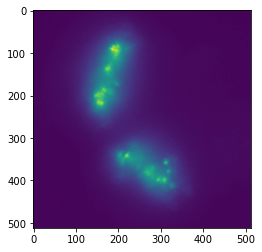

In [10]:
c=1
plane=load_plane(image,z,c,t)
plt.imshow(plane)

In [11]:
tile = (0, 0, image.getSizeX(), image.getSizeY())     # x, y, width, height of tile
# list of [ (0,0,0,(x,y,w,h)), (1,0,0,(x,y,w,h)), (2,0,0,(x,y,w,h))... ]
zct_list = [(iz, c, t, tile) for iz in range(10)]
pixels = image.getPrimaryPixels()
print("\nZ stack of tiles:")
planes = pixels.getTiles(zct_list)
for i, p in enumerate(planes):
    print("Tile:", zct_list[i], " min:", p.min(),\
        " max:", p.max(), " sum:", p.sum())


Z stack of tiles:
Tile: (0, 1, 0, (0, 0, 512, 512))  min: 27  max: 616  sum: 19701069
Tile: (1, 1, 0, (0, 0, 512, 512))  min: 27  max: 604  sum: 19637544
Tile: (2, 1, 0, (0, 0, 512, 512))  min: 26  max: 594  sum: 19592649
Tile: (3, 1, 0, (0, 0, 512, 512))  min: 28  max: 585  sum: 19586735
Tile: (4, 1, 0, (0, 0, 512, 512))  min: 27  max: 619  sum: 19586633
Tile: (5, 1, 0, (0, 0, 512, 512))  min: 27  max: 731  sum: 19606016
Tile: (6, 1, 0, (0, 0, 512, 512))  min: 27  max: 767  sum: 19636424
Tile: (7, 1, 0, (0, 0, 512, 512))  min: 26  max: 744  sum: 19694993
Tile: (8, 1, 0, (0, 0, 512, 512))  min: 26  max: 702  sum: 19731698
Tile: (9, 1, 0, (0, 0, 512, 512))  min: 26  max: 659  sum: 19755707


In [12]:
def get_z_stack(img, c=0, t=0):
    """
    Convert OMERO image object to numpy array
    Input: img  OMERO image object
           c    number of colour channls
           t    number of time steps
    """
    zct_list = [(z, c, t) for z in range(img.getSizeZ())] #Set dimensions of image
    pixels = img.getPrimaryPixels()
    return np.array(list(pixels.getPlanes(zct_list))) #Read in data one plane at a time

In [13]:
stack = get_z_stack(image,c,t)
stack

array([[[41, 33, 32, ..., 35, 38, 32],
        [35, 33, 34, ..., 34, 33, 31],
        [42, 34, 35, ..., 34, 37, 33],
        ...,
        [39, 31, 35, ..., 36, 37, 32],
        [37, 34, 32, ..., 38, 36, 33],
        [38, 34, 34, ..., 34, 40, 31]],

       [[38, 33, 37, ..., 34, 37, 32],
        [38, 35, 36, ..., 35, 40, 35],
        [35, 34, 35, ..., 31, 36, 31],
        ...,
        [38, 30, 36, ..., 39, 38, 36],
        [38, 33, 40, ..., 38, 42, 37],
        [38, 35, 35, ..., 37, 41, 38]],

       [[37, 36, 35, ..., 33, 32, 34],
        [36, 33, 31, ..., 35, 35, 32],
        [38, 31, 34, ..., 35, 35, 32],
        ...,
        [40, 32, 32, ..., 38, 37, 35],
        [35, 35, 32, ..., 39, 37, 33],
        [37, 32, 37, ..., 36, 37, 38]],

       ...,

       [[33, 33, 33, ..., 33, 34, 32],
        [40, 30, 33, ..., 31, 36, 32],
        [38, 32, 33, ..., 30, 38, 32],
        ...,
        [42, 36, 33, ..., 37, 36, 36],
        [41, 40, 37, ..., 36, 37, 35],
        [41, 37, 36, ..., 34, 42

Using getTiles or getPlanes returns a generator of data (not all the data in hand)

Use pixels.getPlanes() to import a hyperstack